In [32]:
# Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 40)

In [33]:
# Collecte des données
data=pd.read_csv("Donnees-sur-le-parc-de-vehicule-au-niveau-regional.2023-05.csv", sep=';',header=[1])

In [34]:
# Variables utiles durant tout le programme
variables = ['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']
regions = data['REGION_LIBELLE'].unique()
regionsr = ['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre-Val de Loire', 'Corse', 'Grand Est', 'Guadeloupe',
       'Guyane', 'Hauts-de-France', 'La Réunion',
       'Martinique', 'Mayotte', 'Normandie', 'Nouvelle-Aquitaine',
       'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur",
       'Île-de-France']
regionsmet = ['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre-Val de Loire', 'Grand Est', 
        'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine',
       'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur",
       'Île-de-France']
regionsmethorsb = ['Auvergne-Rhône-Alpes', 'Bretagne',
       'Centre-Val de Loire', 'Grand Est', 
        'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine',
       'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur",
       'Île-de-France']
critair = data['CRITAIR'].unique()

In [35]:
data = data[data["CATEGORIE_VEHICULE"] == "Véhicule particulier"].reset_index()

   index  PARC_2011  PARC_2012  PARC_2013  PARC_2014  PARC_2015  PARC_2016  \
0      0   35299559   35540253   35787847   36149230   36647883   37180101   
1      0   35299559   35540253   35787847   36149230   36647883   37180101   

   PARC_2017  PARC_2018  PARC_2019  PARC_2020  PARC_2021  PARC_2022  \
0   37673476   38136818   38246432   38435918   38480505   38738396   
1   37673476   38136818   38246432   38435918   38480505   38738396   

   DUMMY_CRITAIR  
0              0  
1              1  


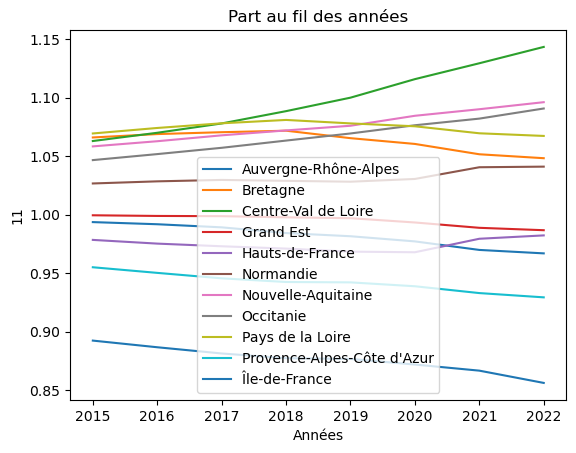

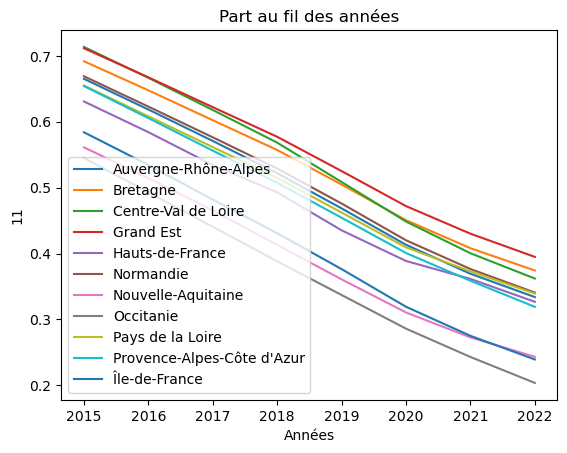

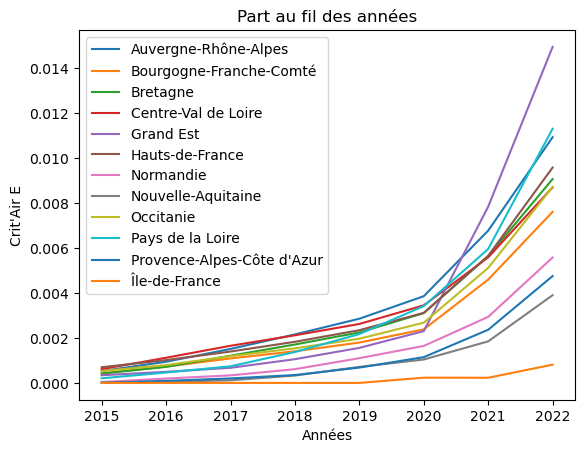

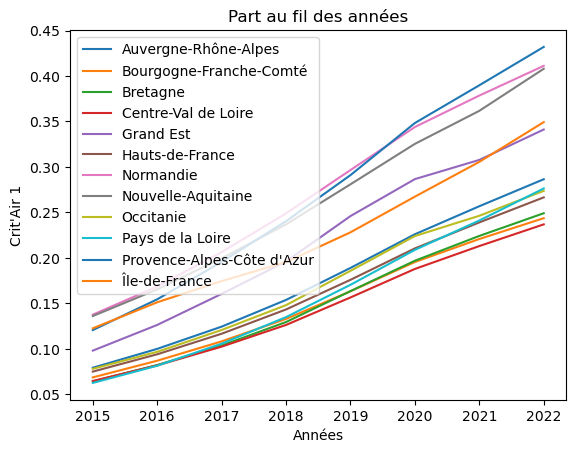

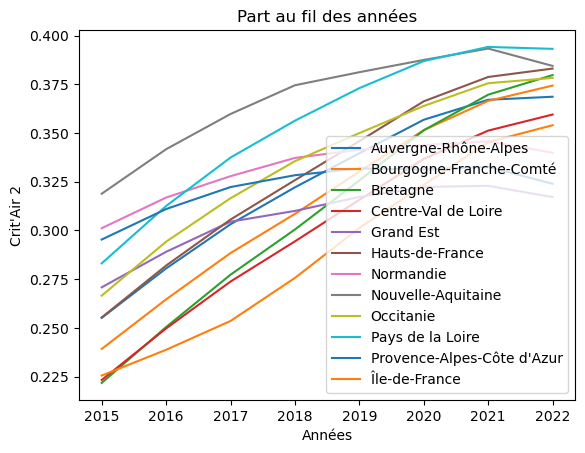

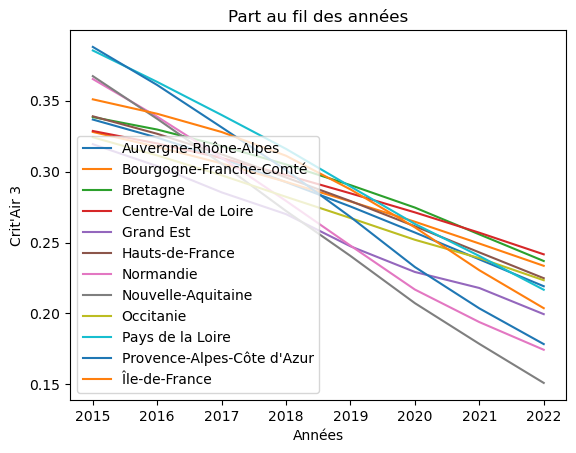

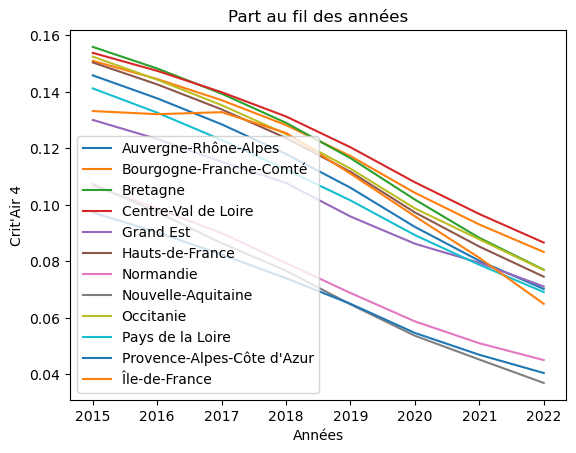

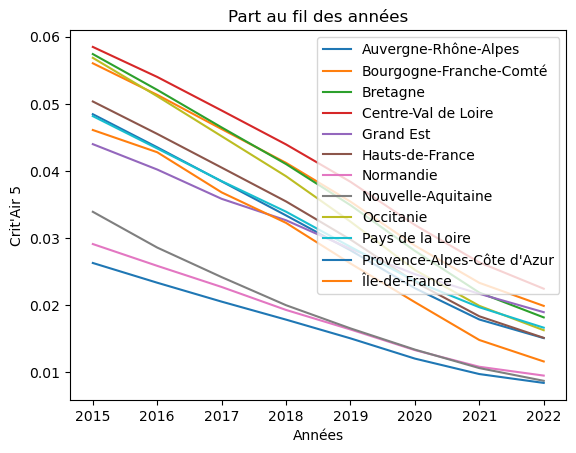

In [36]:
##Création d'une variable "dummy_critair" valant 0 pour les voiture les moins polluantes
data_dummy_critair = data.copy()
data_dummy_critair['DUMMY_CRITAIR'] = data_dummy_critair['CRITAIR'].apply(lambda x : 0 if (x in ["Crit'Air E","Crit'Air 1","Crit'Air 2"]) else 1)


sumregdum = data_dummy_critair.groupby(['REGION_LIBELLE','DUMMY_CRITAIR'])[variables].sum().reset_index()
sumregcrit = data_dummy_critair.groupby(['REGION_LIBELLE','CRITAIR'])[variables].sum().reset_index()
sumreg = data_dummy_critair.groupby(['REGION_LIBELLE'])[variables].sum().reset_index()
sumdum = data_dummy_critair.groupby(['DUMMY_CRITAIR'])[variables].sum().reset_index()
sumall = data_dummy_critair[variables].sum().to_frame().transpose()
result9 = pd.concat([sumall,sumall]).reset_index()
result9['DUMMY_CRITAIR']=[0,1]

print(result9)
ratiotot = sumdum.merge(result9, on=['DUMMY_CRITAIR'], suffixes = ('','_TOT'))
for k in range(11,23):
    ratiotot['PART_20'+str(k)] = ratiotot['PARC_20'+str(k)]/ratiotot['PARC_20'+str(k)+'_TOT']
ratiotot = ratiotot[ratiotot['DUMMY_CRITAIR']==1]
ratiotot = ratiotot[['PART_2011','PART_2012','PART_2013','PART_2014','PART_2015','PART_2016','PART_2017','PART_2018','PART_2019','PART_2020','PART_2021','PART_2022']]

ratiotot2 = pd.concat([ratiotot]*len(regionsmethorsb)).reset_index()
ratiotot2['REGION_LIBELLE'] = regionsmethorsb

sumreg = sumreg.sort_values(by=['REGION_LIBELLE'])
ratio = sumregdum.merge(sumreg, on=['REGION_LIBELLE'], suffixes = ('','_TOT'))
for k in range(11,23):
    ratio['PART_20'+str(k)] = ratio['PARC_20'+str(k)]/ratio['PARC_20'+str(k)+'_TOT']
ratio = ratio[ratio['DUMMY_CRITAIR']==1]
ratio = ratio[['REGION_LIBELLE','PART_2011','PART_2012','PART_2013','PART_2014','PART_2015','PART_2016','PART_2017','PART_2018','PART_2019','PART_2020','PART_2021','PART_2022']]
ratio = ratio.set_index('REGION_LIBELLE')

ratiofinal = ratio.merge(ratiotot2, on=['REGION_LIBELLE'], suffixes = ('','_TOT'))
for k in range(11,23):
    ratiofinal['PART_RELATIVE_20'+str(k)] = ratiofinal['PART_20'+str(k)]/ratiofinal['PART_20'+str(k)+'_TOT']
ratiofinal = ratiofinal[['PART_RELATIVE_2011','PART_RELATIVE_2012','PART_RELATIVE_2013','PART_RELATIVE_2014','PART_RELATIVE_2015','PART_RELATIVE_2016','PART_RELATIVE_2017','PART_RELATIVE_2018','PART_RELATIVE_2019','PART_RELATIVE_2020','PART_RELATIVE_2021','PART_RELATIVE_2022']]

#Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
Années=[2015,2016,2017,2018,2019,2020,2021,2022]
j=0
for c in regionsmethorsb:
    v=ratiofinal.iloc[j]
    v = v[4:]
    plt.plot(Années,v, label=c)
    j+=1

# Ajout des titres et légendes
plt.title('Part au fil des années')
plt.xlabel('Années')
plt.ylabel(i)
plt.legend()
plt.show()

#Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
Années=[2015,2016,2017,2018,2019,2020,2021,2022]
j=0
for c in regionsmethorsb:
    v=ratio.iloc[j]
    v = v[4:]
    plt.plot(Années,v, label=c)
    j+=1

# Ajout des titres et légendes
plt.title('Part au fil des années')
plt.xlabel('Années')
plt.ylabel(i)
plt.legend()
plt.show()

ratio = sumregcrit.merge(sumreg, on=['REGION_LIBELLE'], suffixes = ('','_TOT'))
for k in range(11,23):
    ratio['PART_20'+str(k)] = ratio['PARC_20'+str(k)]/ratio['PARC_20'+str(k)+'_TOT']

for i in ["Crit'Air E","Crit'Air 1","Crit'Air 2","Crit'Air 3","Crit'Air 4","Crit'Air 5"]:
    ratio2 = ratio[ratio['CRITAIR']==i]
    ratio2 = ratio2[['REGION_LIBELLE','PART_2011','PART_2012','PART_2013','PART_2014','PART_2015','PART_2016','PART_2017','PART_2018','PART_2019','PART_2020','PART_2021','PART_2022']]
    ratio2=ratio2.set_index('REGION_LIBELLE')
    
    #Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
    Années=[2015,2016,2017,2018,2019,2020,2021,2022]
    j=0
    for c in regionsmet:
        v=ratio2.iloc[j]
        v = v[4:]
        plt.plot(Années,v, label=c)
        j+=1
    
    # Ajout des titres et légendes
    plt.title('Part au fil des années')
    plt.xlabel('Années')
    plt.ylabel(i)
    plt.legend()
    plt.show()


Concernant les voitures électriques, leur part dans la population de voitures semble croitre exponentiellement.
Cela peut se justifier par le fait que plus de vootures sont produites, plus les coûts diminuent et plus la recherche pour de nouvelles technologies est rentable et donc intensive induisant une équation différentielle de la forme : f'(x) = a.f(x).
Leur part est aujourd'hui de l'ordre d'1%, néanmoins lorsqu'elle sera plus importante, le remplacement des voitures thermiques par des voitures électriques ralentira (voitures thermiques ayant une longue durée de vie, volonté de certaines personnes de ne pas changer de type de véhicule tant qu'ils le peuvent...).
Cela justifie une équation différentielle de la forme : f'(x) = a.f(x)(1-f(x)).
La solution d'une telle équation est de la forme f(x) = exp(ax)/(c+exp(ax)).
Les données disponibles nous permettent de trouver des valeurs probables de a et c avec une méthode de "fitting" : 

                  y   x
PARC_2011  0.000036   1
PARC_2012  0.000105   2
PARC_2013  0.000246   3
PARC_2014  0.000456   4
PARC_2015  0.000691   5
PARC_2016  0.001112   6
PARC_2017  0.001617   7
PARC_2018  0.002156   8
PARC_2019  0.002783   9
PARC_2020  0.003681  10
PARC_2021  0.006374  11
PARC_2022  0.010403  12
Paramètre a ajusté : 0.4284035800845914
Paramètre c ajusté : 16726.157992767003


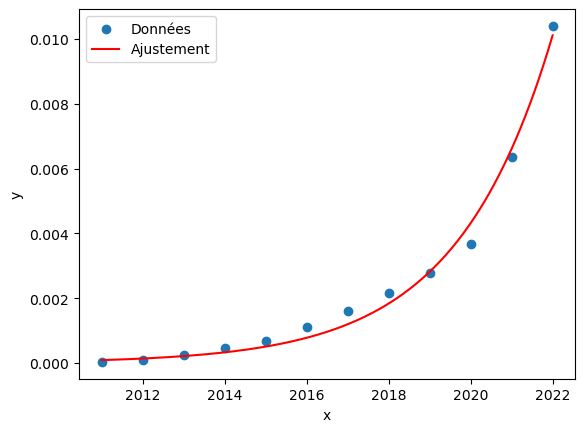

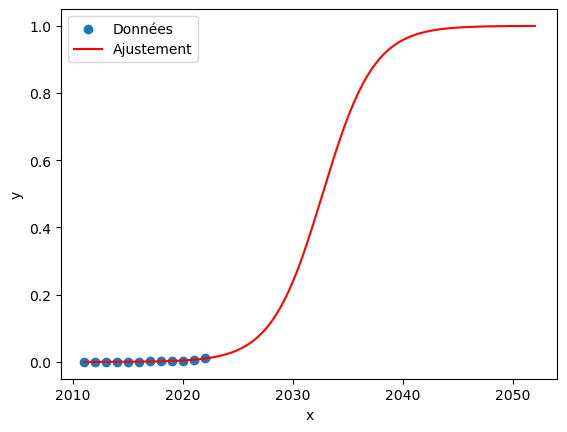

[9.17523649e-05 1.40815113e-04 2.16107517e-04 3.31644648e-04
 5.08919723e-04 7.80880191e-04 1.19799881e-03 1.83751771e-03
 2.81746330e-03 4.31775184e-03 6.61164141e-03 1.01118279e-02
 1.54362110e-02 2.34975982e-02 3.56166582e-02 5.36428504e-02
 8.00352451e-02 1.17796450e-01 1.70079901e-01 2.39275162e-01
 3.25578006e-01 4.25594065e-01 5.32094119e-01 6.35748111e-01
 7.28170538e-01 8.04358941e-01 8.63204857e-01 9.06410248e-01
 9.36966116e-01 9.58008051e-01 9.72233935e-01 9.81732322e-01
 9.88021476e-01 9.92162699e-01 9.94879636e-01]


In [37]:
# Critair E 

données_pour_fit = data[data["CRITAIR"]=="Crit'Air E"][variables].sum().to_frame()
données_pour_fit.columns = ["Crit'Air E"]
tot = data[variables].sum().to_frame()
données_pour_fit['total']=tot
données_pour_fit['y'] = données_pour_fit["Crit'Air E"]/données_pour_fit['total']
données_pour_fit['x'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
données_pour_fit = données_pour_fit[['y','x']]
print(données_pour_fit)

# Fonction à ajuster
def func(x, a, c):
    return np.exp(a*x) / (c + np.exp(a*x))

# curve_fit pour ajuster les paramètres
# Des limites (bounds) sont ajoutées pour les paramètres afin d'éviter les problèmes de nombres trop grands
params, covariance = curve_fit(func, données_pour_fit['x'], données_pour_fit['y'], bounds=([0,0], [10,100000]))

# Valeurs ajustées
a_fit, c_fit = params

# Résultats
print(f"Paramètre a ajusté : {a_fit}")
print(f"Paramètre c ajusté : {c_fit}")

# Courbe ajustée
x_values = np.linspace(min(données_pour_fit['x']), max(données_pour_fit['x']), 300)
y_values_fit = func(x_values, a_fit, c_fit)
x_graph = données_pour_fit['x'] + 2010
x_values += 2010

plt.scatter(x_graph, données_pour_fit['y'], label='Données')
plt.plot(x_values, y_values_fit, color='red', label='Ajustement')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

x_values = np.linspace(min(données_pour_fit['x']), max(données_pour_fit['x'])+30, 300)
y_values_fit = func(x_values, a_fit, c_fit)
x_graph = données_pour_fit['x'] + 2010
x_values += 2010

plt.scatter(x_graph, données_pour_fit['y'], label='Données')
plt.plot(x_values, y_values_fit, color='red', label='Ajustement')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

part_E = func(np.arange(1,36), a_fit, c_fit)
print(part_E)

            PARC_2011  PARC_2012  PARC_2013  PARC_2014  PARC_2015  PARC_2016  \
CRITAIR                                                                        
Crit'Air 1     527854    1117200    1628418    2209327    2843000    3627493   
Crit'Air 2    3789902    5316792    6759839    8048141    9248639   10321928   
Crit'Air 3   13144926   12986403   12702081   12429698   12177620   11904009   
Crit'Air 4    5846557    5728186    5612887    5476668    5331910    5141116   
Crit'Air 5    2353321    2257293    2145067    2016426    1880410    1729316   

            PARC_2017  PARC_2018  PARC_2019  PARC_2020  PARC_2021  PARC_2022  
CRITAIR                                                                       
Crit'Air 1    4573613    5689663    7038271    8486922    9606394   10798122  
Crit'Air 2   11295451   12142060   12842824   13548475   13972530   14155893  
Crit'Air 3   11544080   11109790   10535664    9934637    9280651    8651975  
Crit'Air 4    4897301    4591725    4166628 

/tmp/ipykernel_44064/367141861.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  données_pour_reg[arrivee] = données_pour_reg[depart]/tot[i]
/tmp/ipykernel_44064/367141861.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  données_pour_reg[arrivee] = données_pour_reg[depart]/tot[i]
/tmp/ipykernel_44064/367141861.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  données_pour_reg[arrivee] = données_pour_reg[depart]/tot[i]
/tmp

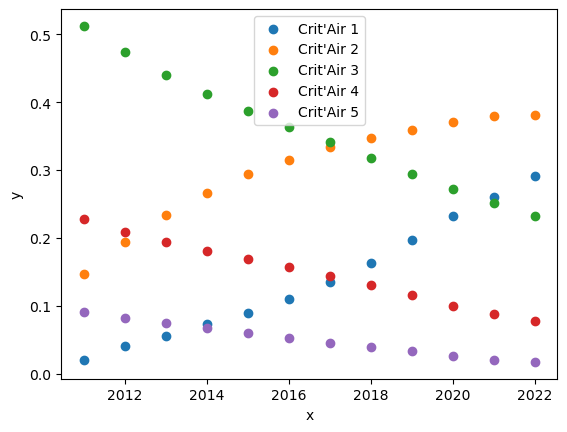

In [38]:
# Part de chaque crit'air parmi les crit'air 1 à 5 (pas de non classées, inconnues très négligeables)
données_pour_reg = data[variables+["CRITAIR"]]
données_pour_reg = données_pour_reg[données_pour_reg["CRITAIR"].isin(["Crit'Air 1", "Crit'Air 2", "Crit'Air 3", "Crit'Air 4", "Crit'Air 5"])].groupby("CRITAIR").sum()
print(données_pour_reg)
tot = données_pour_reg[variables].sum()
liste_tot = tot.tolist()
print(liste_tot)
for i in range(12):
    depart = "PARC_20"+str(i+11)
    arrivee = "Part_20"+str(i+11)
    données_pour_reg[arrivee] = données_pour_reg[depart]/tot[i]

dpr = données_pour_reg[["Part_2011","Part_2012","Part_2013","Part_2014","Part_2015","Part_2016","Part_2017","Part_2018","Part_2019","Part_2020","Part_2021","Part_2022"]]

x_graph = range(2011,2023)
plt.scatter(x_graph, dpr.loc["Crit'Air 1"], label="Crit'Air 1")
plt.scatter(x_graph, dpr.loc["Crit'Air 2"], label="Crit'Air 2")
plt.scatter(x_graph, dpr.loc["Crit'Air 3"], label="Crit'Air 3")
plt.scatter(x_graph, dpr.loc["Crit'Air 4"], label="Crit'Air 4")
plt.scatter(x_graph, dpr.loc["Crit'Air 5"], label="Crit'Air 5")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [57]:
def min0max1(x):
    y=[]
    for i in range(len(x)):
        if x[i] < 0:
            y.append(0)
        elif x[i] > 1:
            y.append(1)
        else:
            y.append(x[i])
    return(np.array(y))

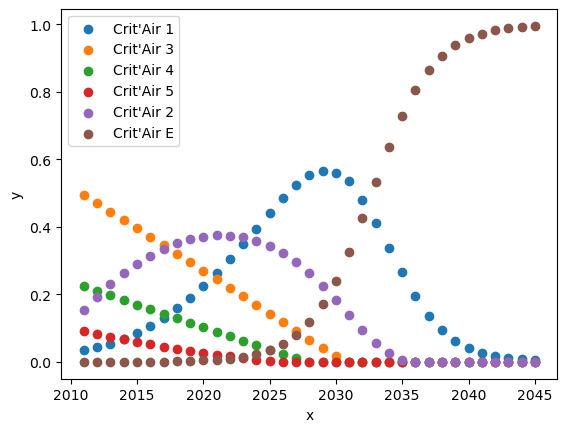

In [66]:
# 4 modèles pour les critair 1, 3 4 et 5
model1 = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()
model4 = LinearRegression()
model5 = LinearRegression()

# Entraînez le modèle sur l'ensemble d'entraînement
years_fit = np.arange(2011, 2023).reshape(-1, 1)
years_squared_fit = years_fit ** 2
x_fit = np.hstack((years_fit, years_squared_fit))
model1.fit(x_fit, np.array(dpr.loc["Crit'Air 1"]))
model2.fit(x_fit, np.array(dpr.loc["Crit'Air 2"]))
#model3.fit(x_fit, np.array(dpr.loc["Crit'Air 3"]))
model4.fit(x_fit, np.array(dpr.loc["Crit'Air 4"]))
model5.fit(x_fit, np.array(dpr.loc["Crit'Air 5"]))
#model1.fit(years_fit, np.array(dpr.loc["Crit'Air 1"]))
#model2.fit(years_fit, np.array(dpr.loc["Crit'Air 2"]))
model3.fit(years_fit, np.array(dpr.loc["Crit'Air 3"]))
#model4.fit(years_fit, np.array(dpr.loc["Crit'Air 4"]))
#model5.fit(years_fit, np.array(dpr.loc["Crit'Air 5"]))

# Faites des prédictions sur l'ensemble de test
years_pred = np.arange(2011, 2046).reshape(-1, 1)
years_squared_pred = years_pred ** 2
x_pred = np.hstack((years_pred, years_squared_pred))
y_pred1 = model1.predict(x_pred)
y_pred2 = model2.predict(x_pred)
#y_pred3 = model3.predict(x_pred)
y_pred4 = model4.predict(x_pred)
y_pred5 = model5.predict(x_pred)
#y_pred1 = model1.predict(years_pred)
#y_pred2 = model2.predict(years_pred)
y_pred3 = model3.predict(years_pred)
#y_pred4 = model4.predict(years_pred)
#y_pred5 = model5.predict(years_pred)

#crit1 = min0max1(y_pred1)
crit2 = min0max1(y_pred2)
crit3 = min0max1(y_pred3)
crit4 = min0max1(y_pred4)
crit5 = min0max1(y_pred5)
crit1 = [1]*35-crit2-crit3-crit4-crit5
crit1_E = crit1*(1-part_E) 
crit2_E = crit2*(1-part_E) 
crit3_E = crit3*(1-part_E) 
crit4_E = crit4*(1-part_E) 
crit5_E = crit5*(1-part_E) 

x_graph = np.arange(2011, 2046)
#plt.scatter(x_graph, crit1, label="Crit'Air 1")
#plt.scatter(x_graph, crit3, label="Crit'Air 3")
#plt.scatter(x_graph, crit4, label="Crit'Air 4")
#plt.scatter(x_graph, crit5, label="Crit'Air 5")
#plt.scatter(x_graph, crit2, label="Crit'Air 2")
plt.scatter(x_graph, crit1_E, label="Crit'Air 1")
plt.scatter(x_graph, crit3_E, label="Crit'Air 3")
plt.scatter(x_graph, crit4_E, label="Crit'Air 4")
plt.scatter(x_graph, crit5_E, label="Crit'Air 5")
plt.scatter(x_graph, crit2_E, label="Crit'Air 2")
plt.scatter(x_graph, part_E, label="Crit'Air E")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

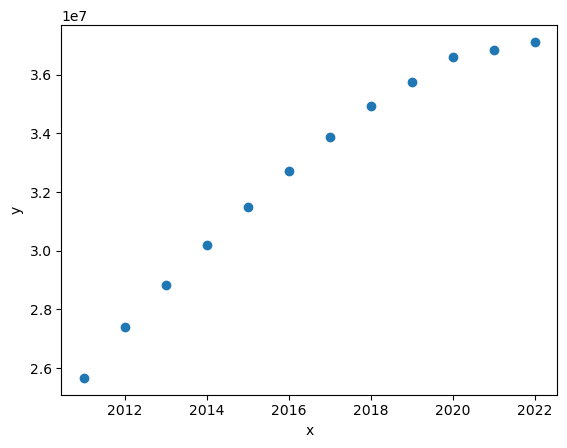

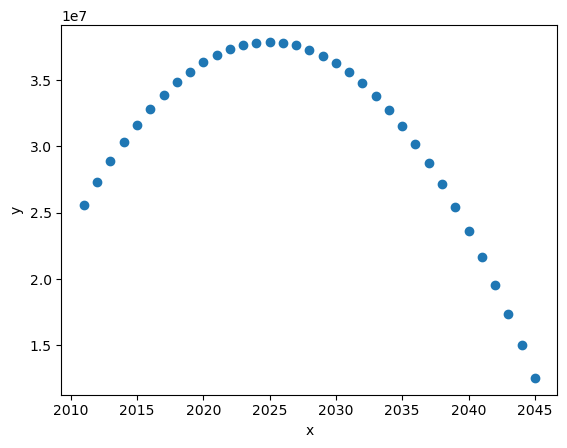

array([ 2.55311816e+08, -6.30413899e+04])

In [113]:
#Nombre total de voiture : nous considérerons ici que la demande de voiture va suivre jusqu'en 2045 sa tendance actuelle.

years_fit = np.arange(2011, 2023).reshape(-1, 1)
years_squared_fit = years_fit ** 2
x_fit = np.hstack((years_fit, years_squared_fit))

plt.scatter(years_fit, (np.array(tot)))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

model = LinearRegression()
model.fit(x_fit, np.array(tot))

years_pred = np.arange(2011, 2046).reshape(-1, 1)
years_squared_pred = years_pred ** 2
x_pred = np.hstack((years_pred, years_squared_pred))

y_pred = model.predict(x_pred)

plt.scatter(years_pred, y_pred)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

model.coef_

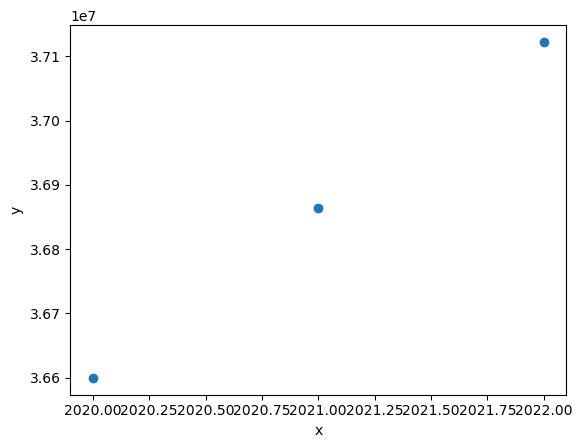

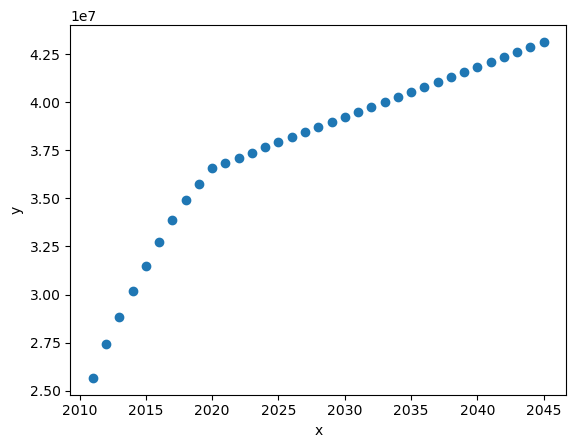

array([261411.5])

In [118]:
#Une solution pour contourner ce problème est de considérer 

years_fit = np.arange(2020, 2023).reshape(-1, 1)

plt.scatter(years_fit, (np.array(tot)[9:]))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

model = LinearRegression()
model.fit(years_fit, np.array(tot)[9:])

years_pred = np.arange(2020, 2046).reshape(-1, 1)

y_pred = model.predict(years_pred)

nb_voitures_pred = np.append(np.array(tot)[:9],(y_pred))

plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voitures_pred)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

model.coef_

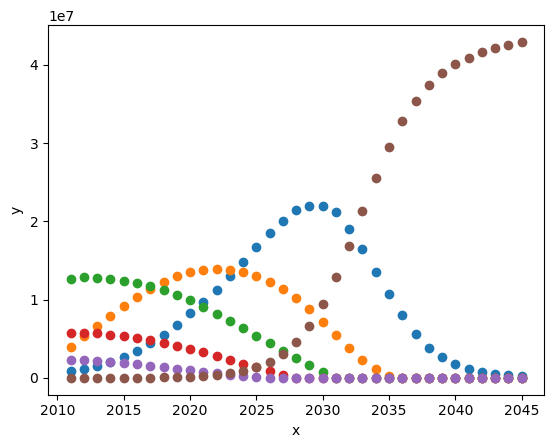

In [119]:
nb_voitures1 = nb_voitures_pred*crit1_E
nb_voitures2 = nb_voitures_pred*crit2_E
nb_voitures3 = nb_voitures_pred*crit3_E
nb_voitures4 = nb_voitures_pred*crit4_E
nb_voitures5 = nb_voitures_pred*crit5_E
nb_voituresE = nb_voitures_pred*part_E

plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voitures1)
plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voitures2)
plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voitures3)
plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voitures4)
plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voitures5)
plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voituresE)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [131]:
calcul_part_diesel = data[["CARBURANT","PARC_2022"]].groupby("CARBURANT").sum()
part_diesel = calcul_part_diesel.loc["Diesel"].iloc[0]/(calcul_part_diesel.loc["Diesel"].iloc[0]+calcul_part_diesel.loc["Essence"].iloc[0])
part_diesel

0.5791841399687028

In [132]:
df_emissions

NameError: name 'df_emissions' is not defined